# Scattering and Tunneling in Quantum Mechanics

This notebook uses the technique from the [TimePropagation_of_WF.ipynb](https://github.com/mholtrop/QMPython/blob/master/TimePropagation_of_WF.ipynb) to investigate scattering and tunneling in one dimensional quantum systems.

We first setup the space and the potential that we are scattering from, and define the function that propagates the wavefunction in time. Details are in the previous notebook.

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as scl
import scipy.fftpack as fft
# Input parameters.
hbar=1
m=1
N = 2**10   # FFT is a lot faster on domains which are powers of 2. 2**12 = 4096, pretty big.
# Define the x-space:
n = np.arange(N)
x_min = -100.
x_max = 100.
Delta_x = (x_max - x_min)/N
print "Delta_x = ",Delta_x
x = x_min + n*Delta_x  # This creates the correct array of x values.
###################################################
# Potential Definition.
###################################################
# A step function can be useful
def step(x):
    return 1*(x>0)

step_low = 10.
step_high= 12.
V0 = 2.
V = V0*(step(x-step_low) - step(x-step_high))
#V=np.zeros(N)
#for i in range(N):
#    if x[i]>= step_low and x[i]<= step_high:
#        V[i]= V0
###################################################
# Setup the Hamiltonian for function V
#
# We need H for several reasons:
# 1) It allows us to calculate <E> of the incoming/outgoing wave functions.
# 2) It allows us to get the energy levels, which helps find the maximum delta t.
#   - to save computation time however, we can use the infinite square well solutions to
#   - get a quite accurate number for the maximum energy. Perhaps more accurate than inverting
#   - the matrix.
E_max = (N-1)**2*np.pi**2*hbar**2/(2*m*(x_max-x_min)**2)
dt_max = 2./E_max
Delta_t = dt_max
if Delta_t>dt_max:
    print "WARNING: dt is in the instable region!!!!!"
print "E_max = {:8.3f}  Delta_t = {:10.7f}".format(E_max,Delta_t)
Mdd = 1./(Delta_x**2)*(np.diag(np.ones(N-1),-1) -2* np.diag(np.ones(N),0) + np.diag(np.ones(N-1),1))
H = -(hbar*hbar)/(2.0*m)*Mdd + np.diag(V) 
# Since usually don't need the energy levels or the wave functions, we comment out the next 2 lines.
En,psiT = np.linalg.eigh(H) # This computes the eigen values and eigenvectors
psi = np.transpose(psiT)   # We take the transpose of psiT to the wavefunction vectors can accessed as psi[n]
# Set the parameters for k-space.
n = np.arange(N)
k0 = -np.pi/Delta_x
kN =  np.pi/Delta_x
Delta_k = (kN-k0)/N
k = k0 + n*Delta_k

Delta_x =  0.1953125
E_max =  129.110  Delta_t =  0.0154906


In [3]:
def Psi_Evolve_N(dt,psi0,N):
    '''This function will evolve the wave function by an amount N*dt and return the new wave function.
    The method for propagating the wave is the split step Fourier method.
    It expects a globally defined x np.array for spacial coordinate, and k np.array for momentum space.
    It also expects a globally defined V np.array for the potential, and variables hbar and m for
    the plank constant (times 2 pi) and mass.'''

    psi_scaled = psi0* np.exp(-1j *k0*x)
    # Take the 1/2 step in x-space with psi_scaled
    psi_scaled *= np.exp(-1j*0.5*V*dt/hbar)
    
    # We now take N-1 times a step in k and a step in x.
    for i in range(N-1):     
        phi_scaled = fft.fft(psi_scaled)
        # Take the step in k-space
        phi_scaled *= np.exp(-1j*hbar**3*k**2*dt/(2*m))
        psi_scaled = fft.ifft(phi_scaled)
        psi_scaled *= np.exp(-1j*V*dt/hbar)
 
    phi_scaled = fft.fft(psi_scaled)
    # Take the last step in k-space
    phi_scaled *= np.exp(-1j*hbar**3*k**2*dt/(2*m))
    psi_scaled = fft.ifft(phi_scaled)
    # Take the last 1/2 step in x-space with psi_scaled
    psi_scaled *= np.exp(-1j*0.5*V*dt/hbar)
    psi_out = psi_scaled* np.exp(+1j *k0*x)
    return(psi_out)

# The Wave functions

In the TimePropagation_of_WF notebook we used a gaussian shaped wave incident on a barrier. This is visually appealing, however such a wave has a spread of energies instead of a single energy, and so it is difficult to compare with any algebraic answer we may have obtained with pencil and paper. It turns out, however, that this is the best we can do. You cannot send in a "sine wave from the left", since that stretches out instantly over all space. If you make
a cutoff point, say just before the barrier, you end up with high frequency components in the wave function that do not propagate nicely in time.

Let us investigate the spread in energy of the gaussian wave function. We can obtain $<E> = <\Psi|\mathrm{H}|\Psi>$, using the Hamiltonian. In code this is a sum over conjugate(Psi) times H.dot(Psi), or `np.sum(np.conjugate(psi_t0)*H.dot(psi_t0))`. We need to take the np.real of this, since calculation errors leave a little remnant of the complex number, and finally if we want to print the number, we need to turn it into a normal float. Similarly, we can compute $<E^2> = <\Psi|\mathrm{H^2}|\Psi>$ using `H.dot(H.dot(psi_t0))`.

For the development of the gaussian wave to be interesting, we need to give it some momentum. How is this done? You can take a stationary gaussian wave in x-space and then transform it to momentum space. You find that in momentum space the shape is still gaussian. Now it we want to add some momentum, we can move the gaussian in momentum space. If you then transform this back, you find that in x-space there is an additional term: $e^{i k_0 x}$, with $k_0=p/\hbar$. We can thus add this term to our gaussian to get it to move. 

Below we calculate a gaussian wave with momenum $k_0$ for various values of $\sigma$, and then plot the absolute of this wave function. We then also compute $<E>$, $<E^2>$ and $\sigma_E$.

In [4]:
g_x0=-40.
g_k0=5.
g_sig=10.

# Gaussian in k-space, where p = \hbar k, with a momentum k0, and x-space psi(x,0) (2a/pi)^1/4 e^{-ax^2}
def psi0(x,g_x0,g_k0,g_sig):
    _Norm_x=np.sqrt(Delta_x/g_sig)/(np.pi**0.25)
    return(_Norm_x*np.exp(-(x-g_x0)**2/(2.*g_sig*g_sig)+1j*g_k0*x))


g_k= 5.0 sigma= 0.1 <E>=  22.040 <E^2>= 793.006 sig_E =  307.256
g_k= 5.0 sigma= 1.0 <E>=  11.677 <E^2>= 145.219 sig_E =    8.868
g_k= 5.0 sigma= 2.0 <E>=  11.573 <E^2>= 136.166 sig_E =    2.241
g_k= 5.0 sigma= 5.0 <E>=  11.543 <E^2>= 133.606 sig_E =    0.360
g_k= 5.0 sigma=10.0 <E>=  11.539 <E^2>= 133.239 sig_E =    0.090
g_k= 5.0 sigma=20.0 <E>=  11.538 <E^2>= 133.151 sig_E =    0.024


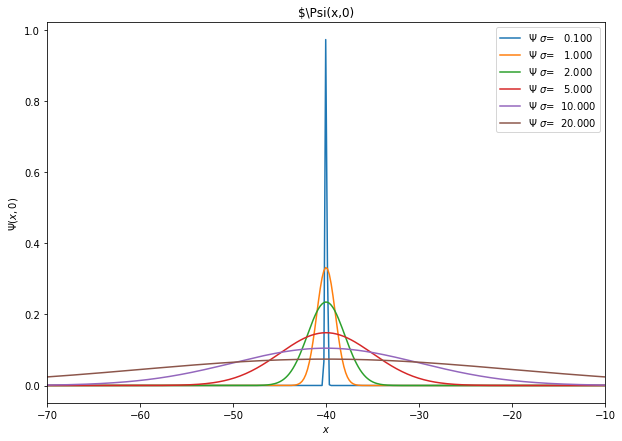

In [5]:
fig,ax1 = plt.subplots(figsize=[10,7])
plt.title('$\Psi(x,0)')
ax1.set_ylabel('$\Psi(x,0)$')
ax1.set_xlabel('$x$')

for sig in [0.1,1.,2.,5.,10.,20.]:
    psi_t0 = psi0(x,g_x0,g_k0,sig)
    E_avg=np.real(np.sum(np.conjugate(psi_t0)*H.dot(psi_t0)))
    E2_avg=np.real(np.sum(np.conjugate(psi_t0)*H.dot(H.dot(psi_t0))))
    E_sig = E2_avg - E_avg**2
    print "g_k={:4.1f} sigma={:4.1f} <E>={:8.3f} <E^2>={:8.3f} sig_E = {:8.3f}".format(g_k0,sig,float(E_avg),float(E2_avg),float(E_sig))
    ax1.plot(x,np.abs(psi_t0),label="$\Psi$ $\sigma$={:8.3f}".format(sig))

ax1.set_xlim(g_x0-30.,g_x0+30)
plt.legend()
plt.show()

We can see that the wider waves have a more defined energy, and that the amount of energy does not change much.
In a similar way we can check how the wave depends on the momentum we give it. We see the energy changes, and $\sigma$ increases proportionally to the energy. 

g_k= 5.0 sigma=10.0 <E>=  11.539 <E^2>= 133.239 sig_E =    0.090
g_k= 2.0 sigma=10.0 <E>=   1.977 <E^2>=   3.928 sig_E =    0.019
g_k= 0.5 sigma=10.0 <E>=   0.127 <E^2>=   0.017 sig_E =    0.001
g_k= 0.0 sigma=10.0 <E>=   0.002 <E^2>=   0.000 sig_E =    0.000


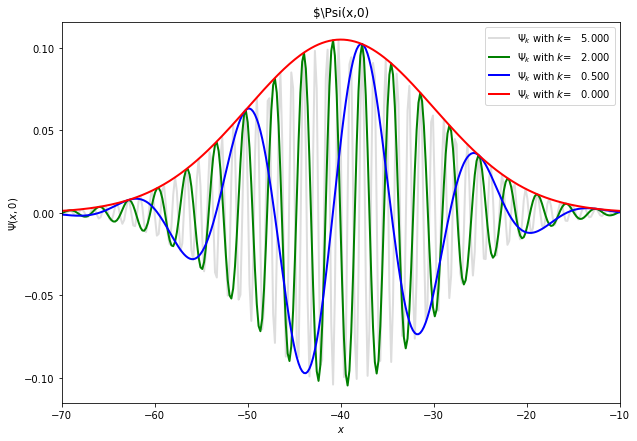

In [6]:
fig,ax1 = plt.subplots(figsize=[10,7])
plt.title('$\Psi(x,0)')
ax1.set_ylabel('$\Psi(x,0)$')
ax1.set_xlabel('$x$')

colors=['red','blue','green','#DDDDDD']
g_k   =[  0. ,  0.5, 2.,  5.]
for i in reversed(range(len(g_k))):
    psi_t0 = psi0(x,g_x0,g_k[i],g_sig)
    E_avg=np.real(np.sum(np.conjugate(psi_t0)*H.dot(psi_t0)))
    E2_avg=np.real(np.sum(np.conjugate(psi_t0)*H.dot(H.dot(psi_t0))))
    E_sig = E2_avg - E_avg**2
    print "g_k={:4.1f} sigma={:4.1f} <E>={:8.3f} <E^2>={:8.3f} sig_E = {:8.3f}".format(g_k[i],g_sig,float(E_avg),float(E2_avg),float(E_sig))
    ax1.plot(x,np.real(psi_t0),linewidth=2,label="$\Psi_k$ with $k$={:8.3f}".format(g_k[i]),color=colors[i])

ax1.set_xlim(g_x0-30.,g_x0+30)
plt.legend()
plt.show()

What we want to construct is a wave function with a well defined energy, which we can set, and only a little bit of momentum. In the algebraic (paper and pencil) case we took a sine wave, however this streches all space and cannot be normalized. Instead, here we will take a sine wave with a wide gaussian envelope.


In [7]:
g_x0=-40.
g_k0=2.
g_sig=10.

psi_t0 = psi0(x,g_x0,g_k0,g_sig)

norm=1.0000+0.0000j <E>=   1.977 <E^2>=   3.928 sig_E =    0.019


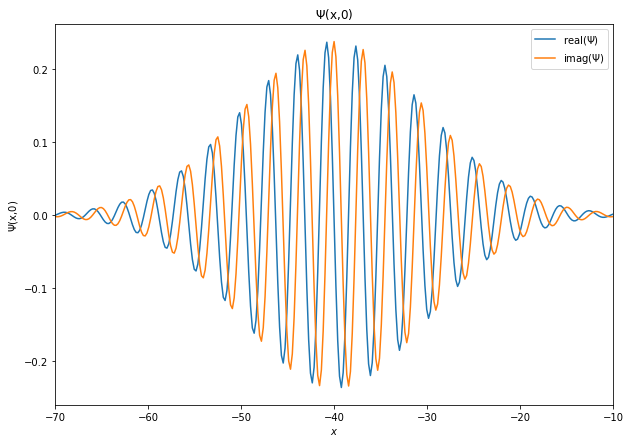

In [8]:
fig,ax1 = plt.subplots(figsize=[10,7])
plt.title('$\Psi$(x,0)')
ax1.set_ylabel('$\Psi$(x,0)')
ax1.set_xlabel('$x$')

norm= np.sum(np.conjugate(psi_t0)*psi_t0)
E_avg=np.real(np.sum(np.conjugate(psi_t0)*H.dot(psi_t0)))
E2_avg=np.real(np.sum(np.conjugate(psi_t0)*H.dot(H.dot(psi_t0))))
E_sig = E2_avg - E_avg**2
print "norm={:6.4f} <E>={:8.3f} <E^2>={:8.3f} sig_E = {:8.3f}".format(norm,float(E_avg),float(E2_avg),float(E_sig))
plt.plot(x,np.real(psi_t0)/np.sqrt(Delta_x),label="real($\Psi$)")
plt.plot(x,np.imag(psi_t0)/np.sqrt(Delta_x),label="imag($\Psi$)")

#    psi_t0 = psi[g_n] #*step(-x) # *np.exp(1.j*6.*x) #psi0(x,g_x0,g_k,g_sig,g_n)
#    norm = np.linalg.norm(psi_t0)
#    psi_t0 = psi_t0/norm
#    norm = np.linalg.norm(psi_t0)
#    E_avg=np.real(np.sum(np.conjugate(psi_t0)*H.dot(psi_t0)))
#    E2_avg=np.real(np.sum(np.conjugate(psi_t0)*H.dot(H.dot(psi_t0))))
#    E_sig = E2_avg - E_avg**2
#    print "g_p={:3d} norm={:6.4f} <E>={:8.3f} <E^2>={:8.3f} sig_E = {:8.3f}".format(g_n,norm,float(E_avg),float(E2_avg),float(E_sig))
#    plt.plot(x,np.real(psi_t0)/np.sqrt(Delta_x),label="p={:3d}".format(g_n))
    
ax1.set_xlim(g_x0-30.,g_x0+30.)
plt.legend()
plt.show()

In [9]:
psi_t1 = psi_t0
psi_t = [(0.,psi_t1)]
for i in range(4):
    t=(i+1)*12000*Delta_t
    psi_t1 = Psi_Evolve_N(Delta_t,psi_t1,12000)
    psi_t.append( (t,psi_t1))

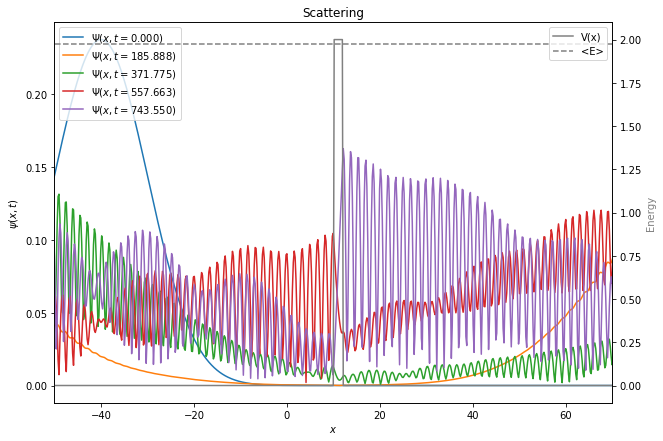

In [10]:
vev_E0 =float(np.real(np.sum(np.conjugate(psi_t0)*H.dot(psi_t0))))
fig,ax1 = plt.subplots(figsize=[10,7])
plt.title('Scattering')
ax1.set_ylabel('$\psi(x,t)$')
ax1.set_xlabel('$x$')
for t,p in psi_t:
    ax1.plot(x,np.abs(p)/np.sqrt(Delta_x),label="$\Psi(x,t={:6.3f})$".format(t))
ax1.legend(loc='upper left')
ax2=ax1.twinx()
ax2.plot(x,V,color="grey",label="V(x)")
ax2.plot([x[0],x[N-1]],[vev_E0,vev_E0],color="grey",linestyle="--",label="<E>")
ax2.set_ylabel("Energy",color="grey")
ax2.set_xlim(-50,70)
ax2.legend(loc='upper right')
#plt.savefig("Displaced_state.pdf")
plt.show()

In [11]:
import matplotlib.animation as animation
from IPython.display import HTML

frame_rate = 10     # Frame rate in Hz. Make higher for smoother movie, but it takes longer to compute.
time_slowdown = 1   # Run time x times slower than normal. we want this about 10.
T=20.                # Total time to animate.
x_min = -100.
x_max = +100.

#%time Ut_1f = np.linalg.matrix_power(Ut_mat,int(1./frame_rate/dt) )  # Moves the wave by one frame according to frame rate
print int(1./frame_rate/Delta_t)

# psi_t0 = psi0(x,g_x0,g_k0,g_sig)
psi_t1 = psi_t0
vev_E0 =float(np.real(np.sum(np.conjugate(psi_t0)*H.dot(psi_t0))))
fig = plt.figure(figsize=[10,7])
plt.title('Scattering')
ax1 = fig.add_subplot(111)
ax1.grid()
ax1.set_ylabel('$\psi(x,t)$')
ax1.set_xlabel('$x$')
ax1.set_xlim(x_min,x_max)
line, = ax1.plot([],[],lw=2,color='red')

time_template = 'time = {:9.2f}s'
time_text = ax1.text(0.05, 0.73, '', transform=ax1.transAxes)


def init():
    ax2=ax1.twinx()
    ax2.plot(x,V,color="grey",label="V(x)")
#    ax2.plot([x_min,x_max],[vev_E0,vev_E0],color="grey",linestyle="--",label="<E>")
    ax2.set_ylabel("Energy",color="grey")
    ax2.legend(loc='upper right')
    ax1.set_xlim(x_min,x_max)
    ax1.set_ylim(-0.1,0.2)
    line.set_data([], [])
    time_text.set_text(time_template.format(0.))
    return line, time_text

def animate(t):
    global psi_t1
    #psi_t1 = Ut_1f.dot(psi_t1)
    psi_t1 = Psi_Evolve_N(Delta_t,psi_t1,int(1./frame_rate/Delta_t))
    line.set_data(x,np.abs(psi_t1/np.sqrt(Delta_x)))
    time_text.set_text(time_template.format(t))
    return line,  time_text

ani = animation.FuncAnimation(fig, animate, np.linspace(0.,T,int(T*frame_rate)),
                              interval=time_slowdown*1000./frame_rate, blit=True, init_func=init)
HTML(ani.to_html5_video())

6
